In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick

import itertools as it

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
today = time.strftime("%Y-%m-%d")

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
month_full = {'01':'January','02':'February','03':'March','04':'April','05':'May',
              '06':'June','07':'July','08':'August','09':'September',
              '10':'October','11':'November','12':'December'}

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                   4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [3]:
city_df = pd.read_csv('massachusetts_municipalities.csv')
city_df = city_df[['city', 'county', 'population', 'date', 'start_date', 'end_date',
         'total_cases', 'total_tests', 'new_tests_town', 'new_cases_town']].copy()
city_df.head()

,city,county,population,date,start_date,end_date,total_cases,total_tests,new_tests_town,new_cases_town
0,Abington,Plymouth,18224,2020-08-05,2020-07-19,2020-08-01,248,3264,211,5
1,Abington,Plymouth,18224,2020-08-12,2020-07-26,2020-08-08,249,3465,201,1
2,Abington,Plymouth,18224,2020-08-19,2020-08-02,2020-08-15,252,3858,393,3
3,Abington,Plymouth,18224,2020-08-26,2020-08-09,2020-08-22,257,4209,351,5
4,Abington,Plymouth,18224,2020-09-02,2020-08-16,2020-08-29,267,4547,338,10


In [4]:
import json
import urllib.request

data_names = ['cases','deaths','testing','vaccines','hospitalization']
base_url = 'https://jhucoronavirus.azureedge.net/api/v1/timeseries/us/'

st_abbrev = 'MA'
dn = data_names[0]
tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
with urllib.request.urlopen(tmp_url) as url_i:
    data_i = json.loads(url_i.read().decode())
st_cases = pd.DataFrame({'date':list(data_i.keys()),
              'new_%s'%dn: [i["raw_positives"] for i in data_i.values()],
              'new_%s_7day_avg'%dn: [i['7-day_avg'] for i in data_i.values()]})

dn = data_names[1]
tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
with urllib.request.urlopen(tmp_url) as url_i:
    data_i = json.loads(url_i.read().decode())
st_deaths = pd.DataFrame({'date':list(data_i.keys()),
              'new_%s'%dn: [i["raw_positives"] for i in data_i.values()],
              'new_%s_7day_avg'%dn: [i['7-day_avg'] for i in data_i.values()]})

dn = data_names[2]
tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
with urllib.request.urlopen(tmp_url) as url_i:
    data_i = json.loads(url_i.read().decode())
st_tests = pd.DataFrame({'date':list(data_i.keys()),
              'new_%s'%dn: [i["raw_tests"] for i in data_i.values()],
              'new_%s_7day_avg'%dn: [i['7-day_avg_positivity'] for i in data_i.values()]})

dn = data_names[3]
tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
with urllib.request.urlopen(tmp_url) as url_i:
    data_i = json.loads(url_i.read().decode())
st_vaccines = pd.DataFrame(data_i)
st_vaccines = st_vaccines.rename(columns={'doses_admin_daily':'new_vaccines','7_day_avg':'new_vaccines_7day_avg'})

dn = data_names[4]
tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
with urllib.request.urlopen(tmp_url) as url_i:
    data_i = json.loads(url_i.read().decode())[0]
st_hosp = pd.DataFrame({'date':list(data_i.keys()),
              'new_%s'%dn: [i["inpatient_beds_used_covid"] for i in data_i.values()],
              'new_%s_7day_avg'%dn: [i['7_day_avg'] for i in data_i.values()]})

st_df = st_cases.merge(st_deaths, how='left', on='date')
st_df = st_df.merge(st_tests, how='left', on='date')
st_df = st_df.merge(st_vaccines, how='left', on='date')
st_df = st_df.merge(st_hosp, how='left', on='date')
st_df['state'] = 'Massachusetts'

ll = st_df.copy()
ll = ll.merge(DATE_DF[['date','week']], how='left', on='date')

jhu_url = 'https://jhucoronavirus.azureedge.net/jhucoronavirus/state_vaccination_rates.json'
with urllib.request.urlopen(jhu_url) as url_i:
    data_i = json.loads(url_i.read().decode())

pop_df = []
for i in range(len(data_i)):
    tmp = data_i[i]['data']
    tmp['state'] = data_i[i]['state']
    pop_df.append(tmp)

pop_df = pd.DataFrame(pop_df)
pop_df['population'] = (pop_df['raw_full_vac'] / pop_df['percent_full_vac'] * 100).astype(int)

ll = ll.merge(pop_df[['state','population','percent_full_vac']], how='left', on='state')

ll['new_cases'] = ll['new_cases_7day_avg']
ll['new_deaths'] = ll['new_deaths_7day_avg']
ll['new_hospitalization'] = ll['new_hospitalization_7day_avg']

ll['new_cases_per1000'] = ll['new_cases'] / ll['population'] * 1000
ll['new_deaths_per1000'] = ll['new_deaths'] / ll['population'] * 1000
ll['new_testing_per1000'] = ll['new_testing'] / ll['population'] * 1000
ll['new_hospitalization_per1000'] = ll['new_hospitalization'] / ll['population'] * 1000

ll = ll[['state', 'population', 'week', 'date',
    'new_cases','new_deaths','new_testing','new_hospitalization', 
    'new_cases_per1000','new_deaths_per1000','new_testing_per1000','new_hospitalization_per1000']].copy()

ll_st = ll.loc[(ll['date']>=city_df['date'].min())&\
            (ll['date']<=city_df['date'].max())].copy().reset_index().iloc[:,1:]
ll_st.head()

,state,population,week,date,new_cases,new_deaths,new_testing,new_hospitalization,new_cases_per1000,new_deaths_per1000,new_testing_per1000,new_hospitalization_per1000
0,Massachusetts,6850553,30,2020-08-05,294.571429,13.571429,25338.0,384.857143,0.043000,0.001981,3.698680,0.056179
1,Massachusetts,6850553,30,2020-08-06,291.857143,13.857143,23143.0,339.142857,0.042603,0.002023,3.378267,0.049506
2,Massachusetts,6850553,30,2020-08-07,291.714286,13.285714,21888.0,343.857143,0.042583,0.001939,3.195071,0.050194
3,Massachusetts,6850553,30,2020-08-08,289.285714,13.428571,12031.0,347.142857,0.042228,0.001960,1.756209,0.050674
4,Massachusetts,6850553,30,2020-08-09,284.428571,15.714286,7683.0,349.714286,0.041519,0.002294,1.121515,0.051049


In [5]:
ld = ll_st.date.unique().tolist()[-1]
fd = ll_st.date.unique().tolist()[0]
ld = month_dict[ld[5:7]]+" "+ld[-2:]+", "+ld[:4]
fd = month_dict[fd[5:7]]+" "+fd[-2:]+", "+fd[:4]

# Layout: 32 x 22 subplot

In [6]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [7]:
gridvals = pd.read_csv('massachusetts_grid.csv', sep='\t')
city_grid = dict(zip(gridvals['city'].values,[eval(i) for i in gridvals['tuple'].values]))
grid_city = {j:i for i,j in city_grid.items()}
city_names_short = dict(zip(gridvals['city'].values,gridvals['city_short'].values))

In [8]:
gridvals.head()

,tuple,city,city_short
0,"(14, 21)",Abington,Abington
1,"(5, 18)",Acton,Acton
2,"(17, 22)",Acushnet,Acushnet
3,"(5, 2)",Adams,Adams
4,"(12, 6)",Agawam,Agawam


2021-12-07 13:41:03.674696 Merrimac (0, 21)
2021-12-07 13:41:03.749237 Amesbury (0, 22)
2021-12-07 13:41:03.819468 Salisbury (0, 23)
2021-12-07 13:41:03.896736 Methuen (1, 19)
2021-12-07 13:41:03.972627 Haverhill (1, 20)
2021-12-07 13:41:04.046578 West Newbury (1, 21)
2021-12-07 13:41:04.116207 Newbury (1, 22)
2021-12-07 13:41:04.190079 Newburyport (1, 23)
2021-12-07 13:41:04.258367 Townsend (2, 15)
2021-12-07 13:41:04.324968 Pepperell (2, 16)
2021-12-07 13:41:04.396084 Dunstable (2, 17)
2021-12-07 13:41:04.462294 Tyngsborough (2, 18)
2021-12-07 13:41:04.530980 Dracut (2, 19)
2021-12-07 13:41:04.603233 Groveland (2, 20)
2021-12-07 13:41:04.673226 Georgetown (2, 21)
2021-12-07 13:41:04.740323 Rowley (2, 22)
2021-12-07 13:41:04.818098 Ipswich (2, 23)
2021-12-07 13:41:04.883871 Essex (2, 24)
2021-12-07 13:41:05.245512 Clarksburg (3, 0)
2021-12-07 13:41:05.318349 Monroe (3, 1)
2021-12-07 13:41:05.390799 Rowe (3, 2)
2021-12-07 13:41:05.460727 Heath (3, 3)
2021-12-07 13:41:05.536851 Colrain 

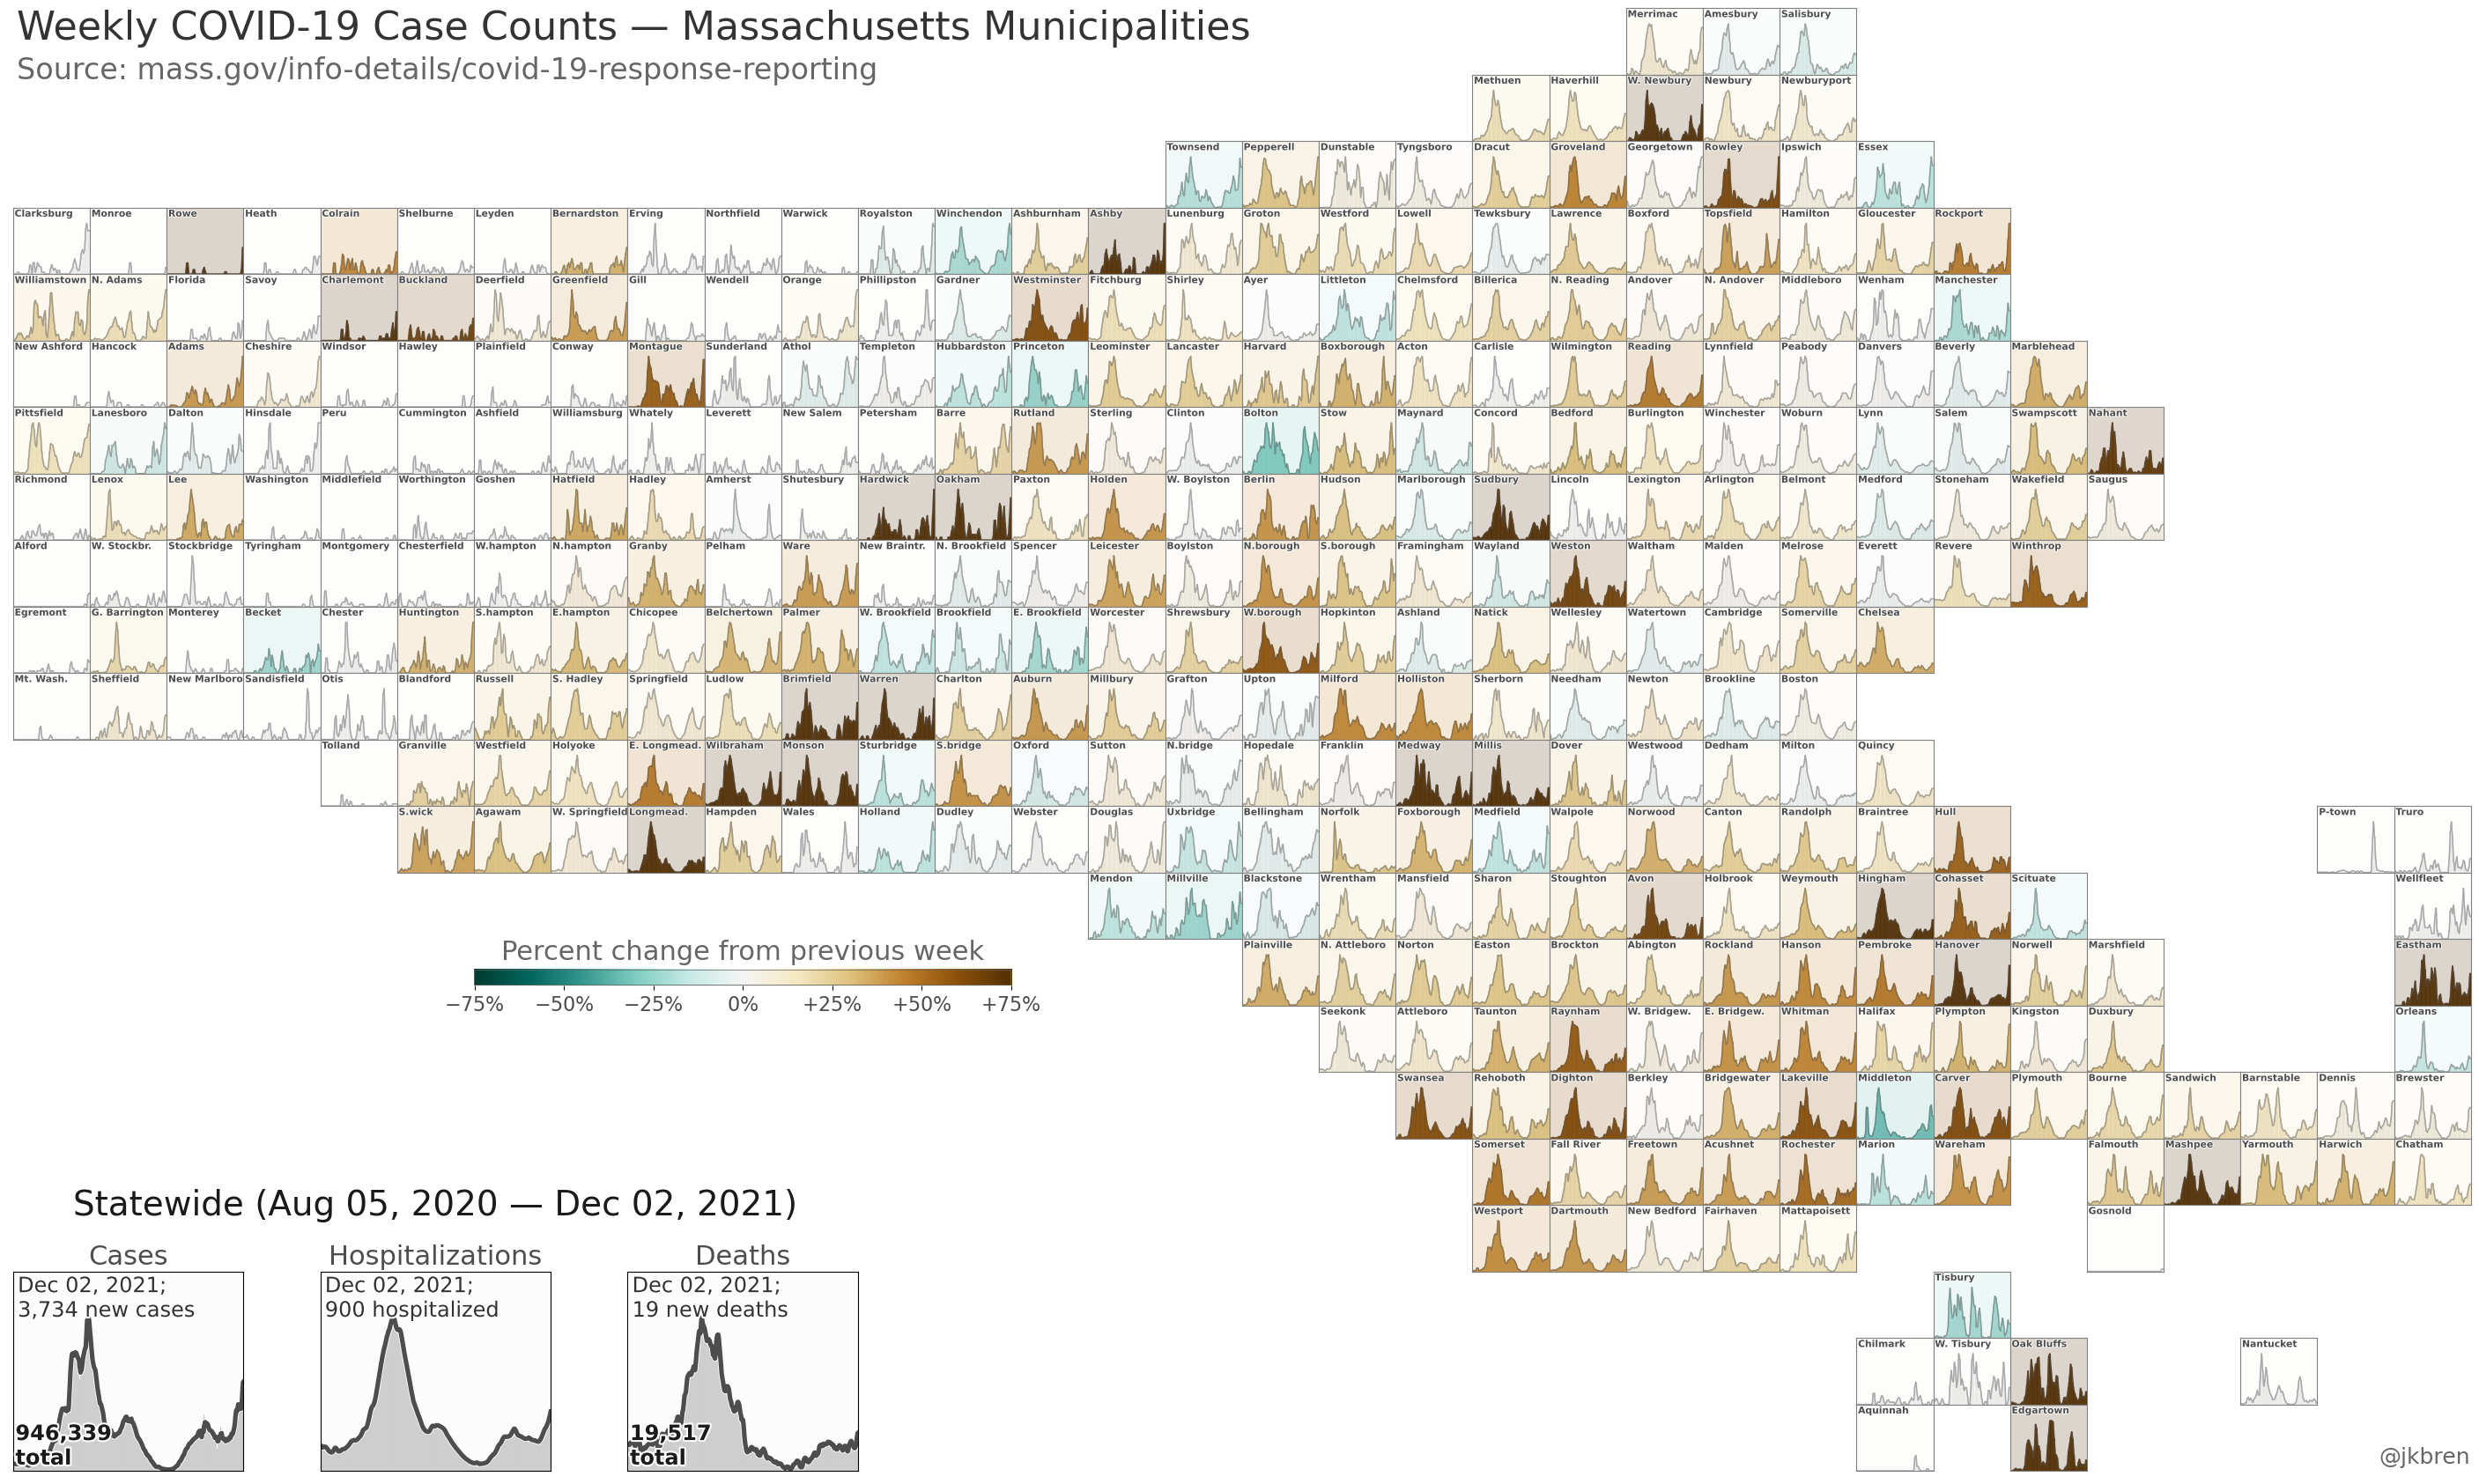

In [9]:
wid = 2
minv = 5
lw = 2.5
w = 1.125; h = 1.0
ncols = 32; nrows = 22
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)
plt.subplots_adjust(wspace=0.0,hspace=0.0)

show_tups = False
city_tups = list(city_grid.values())
vmi = -0.75; vma = 0.75
for ti in tups:
    aa = ax[ti]

    if ti not in city_tups:
        if show_tups:
            aa.text(0.5, 0.5, ti, ha='center', va='center', fontsize='small', color='.9')
            for sp in ['left', 'top', 'bottom', 'right']:
                aa.spines[sp].set_color('.8')
                aa.spines[sp].set_linewidth(0.5)
        else:
            aa.set_axis_off()

    else:
        ci = grid_city[ti]
        print(dt.datetime.now(),ci,ti)
        aa = ax[ti]
        cti = city_df.loc[city_df['city']==ci].copy()
        xvals_i = [date_dict[i] for i in cti['date']]
        yvals_i = list(cti['new_cases_town'].rolling(window=wid).mean().values)
        recent_trend = cti['new_cases_town'].rolling(window=wid).mean().pct_change().values[-1]
        if np.isnan(recent_trend):
            recent_trend = 0.0
        if yvals_i[-1] < minv:
            recent_trend = 0.0

        norm = matplotlib.colors.Normalize(vmin=vmi, vmax=vma)
        cmap = matplotlib.cm.get_cmap('BrBG_r')
        col_co = cmap(norm(recent_trend))

        x = xvals_i+[xvals_i[-1]+2]
        y = yvals_i+[yvals_i[-1]]
        xs = [x[0] - 3.5]
        ys = [0]
        for i in range(len(x)):
            xs.append(x[i] - 0.5)
            xs.append(x[i] + 0.5)
            ys.append(y[i])
            ys.append(y[i])

        aa.bar(xvals_i+[xvals_i[-1]+2], yvals_i+[yvals_i[-1]], width=8, lw=0, fc='.6')
        aa.bar(xvals_i+[xvals_i[-1]+2], yvals_i+[yvals_i[-1]], width=8, lw=0, fc=col_co, alpha=0.9)
        aa.plot(xs, ys, color='.35', lw=1.0)
        aa.plot(xs, ys, color=col_co, alpha=0.5, lw=1.2)

        aa.set_xticks([])
        aa.set_yticks([])
        ylimi = aa.get_ylim()
        yvm = np.nanmax(ylimi)*1.25
        if yvm < 10:
            yvm = 15
        aa.fill_between([date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]+10],
                        0, yvm, alpha=0.2, color=col_co, lw=0, zorder=0)
        aa.set_ylim(0,yvm)
        aa.set_xlim(date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]+6)
        aa.text(0.02, 0.97, city_names_short[ci], ha='left', va='top',
                fontsize=7.75, transform=aa.transAxes, fontweight='bold',
                path_effects=[path_effects.Stroke(linewidth=1.25, foreground='w'),
                              path_effects.Normal()], color='.3')
        for sp in ['left', 'top', 'bottom', 'right']:
            aa.spines[sp].set_color('.5')


ax[tups[0]].text(date_dict[city_df['date'].min()]+20, 0.99,
                 'Weekly COVID-19 Case Counts — Massachusetts Municipalities', 
                 fontsize=32, color='.2', ha='left', va='top')
ax[tups[0]].text(date_dict[city_df['date'].min()]+20, -0.15,
                 'Source: mass.gov/info-details/covid-19-response-reporting',
                 fontsize=24, color='.4', ha='left', va='bottom')
ax[tups[0]].set_ylim(0, 1)
ax[tups[0]].set_xlim(date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]+6)

ax[tups[-1]].text(date_dict[city_df['date'].max()], 0.05, '@jkbren', 
                  fontsize=18, color='.4', ha='right', va='bottom')
ax[tups[-1]].set_ylim(0, 1)
ax[tups[-1]].set_xlim(date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]+6)

gs0 = ax[14,6].get_gridspec()
for a in ax[14:15, 6:13].flatten():
    a.remove()
axbig0 = fig.add_subplot(gs0[14:15, 6:13])
axbig0.set_axis_off()
axbig0 = axbig0.inset_axes([0.0, 0.3, 1.0, 0.6])

cb0 = np.linspace(vmi, vma, 256).reshape(1, 256)
axbig0.set_title('Percent change from previous week', fontsize=22, color='.4', y=0.99, va='top')
axbig0.imshow(cb0, cmap=cmap, extent=[0, 1, 1, 0], aspect='auto', vmin=vmi, vmax=vma)
axbig0.hlines(1,0,1,color='.4',lw=0.50)
axbig0.hlines(0,0,1,color='.4',lw=1.25)
axbig0.vlines(1,0,1,color='.4',lw=1.25)
axbig0.vlines(0,0,1,color='.4',lw=1.25)
axbig0.set_yticks([])
axbig0.set_xticks(np.linspace(0.001,0.999,7))
axbig0.set_xticklabels(['$-75$%','$-50$%','$-25$%','$0$%',
                        '$+25$%','$+50$%','$+75$%'], fontsize=16, color='.3')
axbig0.set_ylim(0,2.5)
axbig0.spines['bottom'].set_visible(False)
axbig0.spines['left'].set_visible(False)
axbig0.spines['right'].set_visible(False)
axbig0.spines['top'].set_visible(False)
axbig0.xaxis.set_ticks_position('bottom')

gs1 = ax[19,0].get_gridspec()
for a in ax[19:, 0:3].flatten():
    a.remove()
axbig1 = fig.add_subplot(gs1[19:, 0:3])

gs2 = ax[19,4].get_gridspec()
for a in ax[19:, 4:7].flatten():
    a.remove()
axbig2 = fig.add_subplot(gs2[19:, 4:7])

gs3 = ax[19,8].get_gridspec()
for a in ax[19:, 8:11].flatten():
    a.remove()
axbig3 = fig.add_subplot(gs3[19:, 8:11])

stlab = 'Massachusetts'
ll_stx = ll_st.copy()
cols = ['new_cases','new_hospitalization','new_deaths']
labs1 = ['Cases','Hospitalizations','Deaths']
labs2 = ['new cases','hospitalized','new deaths']

for ix,axbig_i in enumerate([axbig1,axbig2,axbig3]):
    hosp_col = cols[ix]
    xvals_st = [date_dict[i] for i in sorted(ll_stx['date'].tolist())]
    yvals_st = ll_stx[hosp_col].rolling(window=3).mean().tolist()
    yvals_st_raw = ll_stx[hosp_col].tolist()
    most_recent_st = int(yvals_st_raw[-1])

    axbig_i.plot(xvals_st, yvals_st, color='.3', linewidth=lw*1.5,
                path_effects=[path_effects.Stroke(linewidth=lw*2, foreground='w'),
                              path_effects.Normal()])
    axbig_i.bar(xvals_st, yvals_st_raw, color='.5', alpha=0.4, width=1, linewidth=0.1, ec='w')
    axbig_i.fill_between([date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]],
                        np.nanmax(yvals_st)*1.3,color='.9',alpha=0.1,zorder=0)
    axbig_i.set_xticks([])
    axbig_i.set_yticks([])
    axbig_i.set_ylim(0, np.nanmax(yvals_st)*1.3)
    axbig_i.set_xlim(date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()])
    axbig_i.text(0.02,0.98,'%s;\n%s %s'%(ld, "{:,}".format(most_recent_st), labs2[ix]),
            fontsize='xx-large',va='top',ha='left', color='.2',transform=axbig_i.transAxes,
            path_effects=[path_effects.Stroke(linewidth=3, foreground='w'),
                          path_effects.Normal()])
    axbig_i.set_title(labs1[ix], fontsize=22, color='.3')
    if ix != 1:
        total_st_i = int(sum(ll[hosp_col].tolist()))
        axbig_i.text(0.01,0.01,'%s\ntotal'%("{:,}".format(total_st_i)),
            fontsize='xx-large',va='bottom',ha='left',
            color='.1',fontweight='bold',transform=axbig_i.transAxes,
            path_effects=[path_effects.Stroke(linewidth=3, foreground='w'),
                          path_effects.Normal()])
    else:
        axbig_i.text(0.5, 1.25, 'Statewide (%s — %s)'%(fd, ld), fontsize=28, color='.1',
                     ha='center', va='bottom', transform=axbig_i.transAxes)


plt.savefig('ma_grid_cartogram_div_current.png',dpi=425,bbox_inches='tight')
plt.show()

_________________

# Making a .gif

In [10]:
datespan = [i for i in city_df['date'].unique() if i >= '2020-10-02']
di = datespan[0]

In [11]:
wid = 2
minv = 5
lw = 2.5
w = 1.125; h = 1.0
ncols = 32; nrows = 22

for di in datespan:
    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)
    plt.subplots_adjust(wspace=0.0,hspace=0.0)

    print(dt.datetime.now(),di)

    city_dfx = city_df.loc[city_df['date']<=di].copy()
    show_tups = False
    city_tups = list(city_grid.values())
    vmi = -0.75; vma = 0.75
    for ti in tups:
        aa = ax[ti]

        if ti not in city_tups:
            if show_tups:
                aa.text(0.5, 0.5, ti, ha='center', va='center', fontsize='small', color='.9')
                for sp in ['left', 'top', 'bottom', 'right']:
                    aa.spines[sp].set_color('.8')
                    aa.spines[sp].set_linewidth(0.5)
            else:
                aa.set_axis_off()

        else:
            ci = grid_city[ti]
            aa = ax[ti]
            cti = city_dfx.loc[city_dfx['city']==ci].copy()
            xvals_i = [date_dict[i] for i in cti['date']]
            yvals_i = list(cti['new_cases_town'].rolling(window=wid).mean().values)
            recent_trend = cti['new_cases_town'].rolling(window=wid).mean().pct_change().values[-1]
            if np.isnan(recent_trend):
                recent_trend = 0.0
            if yvals_i[-1] < minv:
                recent_trend = 0.0

            norm = matplotlib.colors.Normalize(vmin=vmi, vmax=vma)
            cmap = matplotlib.cm.get_cmap('BrBG_r')
            col_co = cmap(norm(recent_trend))

            x = xvals_i+[xvals_i[-1]+2]
            y = yvals_i+[yvals_i[-1]]
            xs = [x[0] - 3.5]
            ys = [0]
            for i in range(len(x)):
                xs.append(x[i] - 0.5)
                xs.append(x[i] + 0.5)
                ys.append(y[i])
                ys.append(y[i])

            aa.bar(xvals_i+[xvals_i[-1]+2], yvals_i+[yvals_i[-1]], width=8, lw=0, fc='.6')
            aa.bar(xvals_i+[xvals_i[-1]+2], yvals_i+[yvals_i[-1]], width=8, lw=0, fc=col_co, alpha=0.9)
            # aa.plot(xs, ys, color='.2', lw=0.7)
            # aa.plot(xs, ys, color=col_co, alpha=0.9, lw=1.0)
            aa.plot(xs, ys, color='.35', lw=1.0)
            aa.plot(xs, ys, color=col_co, alpha=0.5, lw=1.2)

            aa.set_xticks([])
            aa.set_yticks([])
            ylimi = aa.get_ylim()
            yvm = np.nanmax(ylimi)*1.25
            if yvm < 10:
                yvm = 15
            aa.fill_between([date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]+10],
                            0, yvm, alpha=0.2, color=col_co, lw=0, zorder=0)
            aa.set_ylim(0,yvm)
            aa.set_xlim(date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]+6)
            aa.text(0.02, 0.97, city_names_short[ci], ha='left', va='top',
                    fontsize=7.75, transform=aa.transAxes, fontweight='bold',
                    path_effects=[path_effects.Stroke(linewidth=1.25, foreground='w'),
                                  path_effects.Normal()], color='.3')
            for sp in ['left', 'top', 'bottom', 'right']:
                aa.spines[sp].set_color('.5')


    ax[tups[0]].text(date_dict[city_df['date'].min()]+20, 0.99,
                     'Weekly COVID-19 Case Counts — Massachusetts Municipalities', 
                     fontsize=32, color='.2', ha='left', va='top')
    ax[tups[0]].text(date_dict[city_df['date'].min()]+20, -0.15,
                     'Source: mass.gov/info-details/covid-19-response-reporting',
                     fontsize=24, color='.4', ha='left', va='bottom')
    ax[tups[0]].set_ylim(0, 1)
    ax[tups[0]].set_xlim(date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]+6)

    ax[tups[-1]].text(date_dict[city_df['date'].max()], 0.05, '@jkbren', 
                      fontsize=18, color='.4', ha='right', va='bottom')
    ax[tups[-1]].set_ylim(0, 1)
    ax[tups[-1]].set_xlim(date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]+6)

    gs0 = ax[14,6].get_gridspec()
    for a in ax[14:15, 6:13].flatten():
        a.remove()
    axbig0 = fig.add_subplot(gs0[14:15, 6:13])
    axbig0.set_axis_off()
    axbig0 = axbig0.inset_axes([0.0, 0.3, 1.0, 0.6])

    cb0 = np.linspace(vmi, vma, 256).reshape(1, 256)
    axbig0.set_title('Percent change from previous week', fontsize=22, color='.4', y=0.99, va='top')
    axbig0.imshow(cb0, cmap=cmap, extent=[0, 1, 1, 0], aspect='auto', vmin=vmi, vmax=vma)
    axbig0.hlines(1,0,1,color='.4',lw=0.50)
    axbig0.hlines(0,0,1,color='.4',lw=1.25)
    axbig0.vlines(1,0,1,color='.4',lw=1.25)
    axbig0.vlines(0,0,1,color='.4',lw=1.25)
    axbig0.set_yticks([])
    axbig0.set_xticks(np.linspace(0.001,0.999,7))
    axbig0.set_xticklabels(['$-75$%','$-50$%','$-25$%','$0$%',
                            '$+25$%','$+50$%','$+75$%'], fontsize=16, color='.3')
    axbig0.set_ylim(0,2.5)
    axbig0.spines['bottom'].set_visible(False)
    axbig0.spines['left'].set_visible(False)
    axbig0.spines['right'].set_visible(False)
    axbig0.spines['top'].set_visible(False)
    axbig0.xaxis.set_ticks_position('bottom')

    gs1 = ax[19,0].get_gridspec()
    for a in ax[19:, 0:3].flatten():
        a.remove()
    axbig1 = fig.add_subplot(gs1[19:, 0:3])

    gs2 = ax[19,4].get_gridspec()
    for a in ax[19:, 4:7].flatten():
        a.remove()
    axbig2 = fig.add_subplot(gs2[19:, 4:7])

    gs3 = ax[19,8].get_gridspec()
    for a in ax[19:, 8:11].flatten():
        a.remove()
    axbig3 = fig.add_subplot(gs3[19:, 8:11])

    stlab = 'Massachusetts'
    ll_stx = ll_st.loc[ll_st['date']<=di].copy()
    cols = ['new_cases','new_hospitalization','new_deaths']
    labs1 = ['Cases','Hospitalizations','Deaths']
    labs2 = ['new cases','hospitalized','new deaths']

    for ix,axbig_i in enumerate([axbig1,axbig2,axbig3]):
        hosp_col = cols[ix]
        xvals_st = [date_dict[i] for i in sorted(ll_stx['date'].tolist())]
        yvals_st = ll_stx[hosp_col].rolling(window=3).mean().tolist()
        yvals_st_raw = ll_stx[hosp_col].tolist()
        most_recent_st = int(yvals_st_raw[-1])

        axbig_i.plot(xvals_st, yvals_st, color='.3', linewidth=lw*1.5,
                    path_effects=[path_effects.Stroke(linewidth=lw*2, foreground='w'),
                                  path_effects.Normal()])
        axbig_i.bar(xvals_st, yvals_st_raw, color='.5', alpha=0.4, width=1, linewidth=0.1, ec='w')
        axbig_i.fill_between([date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()]],
                            np.nanmax(yvals_st)*1.3,color='.9',alpha=0.1,zorder=0)

        ldi = month_dict[di[5:7]]+" "+di[-2:]+", "+di[:4]
        axbig_i.set_xticks([])
        axbig_i.set_yticks([])
        axbig_i.set_ylim(0, np.nanmax(yvals_st)*1.3)
        axbig_i.set_xlim(date_dict[city_df['date'].min()]-1,date_dict[city_df['date'].max()])
        axbig_i.text(0.02,0.98,'%s;\n%s %s'%(ldi, "{:,}".format(most_recent_st), labs2[ix]),
                fontsize='xx-large',va='top',ha='left', color='.2',transform=axbig_i.transAxes,
                path_effects=[path_effects.Stroke(linewidth=3, foreground='w'),
                              path_effects.Normal()])
        axbig_i.set_title(labs1[ix], fontsize=22, color='.3')
        if ix != 1:
            total_st_i = int(sum(ll.loc[ll['date']<=di][hosp_col].tolist()))
            axbig_i.text(0.01,0.01,'%s\ntotal'%("{:,}".format(total_st_i)),
                fontsize='xx-large',va='bottom',ha='left',
                color='.1',fontweight='bold',transform=axbig_i.transAxes,
                path_effects=[path_effects.Stroke(linewidth=3, foreground='w'),
                              path_effects.Normal()])
        else:
            axbig_i.text(0.5, 1.25, 'Statewide (%s — %s)'%(fd, ldi), fontsize=28, color='.1',
                         ha='center', va='bottom', transform=axbig_i.transAxes)


    plt.savefig('gifs/ma_grid_cartogram_div_%s.png'%di,dpi=425,bbox_inches='tight')
    plt.close()
    # plt.show()

2021-12-07 13:43:37.051932 2020-10-07
2021-12-07 13:44:25.108572 2020-10-14
2021-12-07 13:45:05.141372 2020-10-22
2021-12-07 13:45:50.231360 2020-10-29
2021-12-07 13:46:39.205406 2020-11-06
2021-12-07 13:47:28.856493 2020-11-12
2021-12-07 13:48:25.340302 2020-11-19
2021-12-07 13:49:19.303069 2020-11-27
2021-12-07 13:50:13.398896 2020-12-03
2021-12-07 13:51:08.102050 2020-12-10
2021-12-07 13:51:59.224668 2020-12-17
2021-12-07 13:52:56.193466 2020-12-24
2021-12-07 13:53:56.598631 2020-12-31
2021-12-07 13:54:49.383123 2021-01-07
2021-12-07 13:55:57.862162 2021-01-14
2021-12-07 13:56:50.949632 2021-01-21
2021-12-07 13:58:03.503504 2021-01-28
2021-12-07 13:58:53.839754 2021-02-04
2021-12-07 14:00:09.148826 2021-02-11
2021-12-07 14:01:05.595089 2021-02-18
2021-12-07 14:02:26.429710 2021-02-25
2021-12-07 14:03:20.087780 2021-03-04
2021-12-07 14:04:47.943632 2021-03-11
2021-12-07 14:05:47.692882 2021-03-18
2021-12-07 14:06:47.542398 2021-03-25
2021-12-07 14:08:26.046917 2021-04-01
2021-12-07 1